# Data Preparation

In [1]:
from comet_ml import Experiment
import sys
sys.path.append('../ift6758/data/')
from question_2_m2 import *
from question_4_m2 import get_new_features, get_angle_change
import numpy as np
import json
import time
import json
import pandas as pd
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('final_df.csv')

In [3]:
df = df[df['season_type'] == 'R']

In [4]:
# keep only numeric columns
df = df.select_dtypes(include=np.number)

# drop some irrelevant columns
cols_to_drop = ['game_id', 'event_id', 'shot_ind', 'x_coordinates', 'y_coordinates', 
                'previous_event_x_coordinates', 'previous_event_y_coordinates', 'previous_event_period', 
                'home_players', 'away_players', 'previous_event_game_seconds', 'previous_event_game_seconds']
df = df.drop(columns = cols_to_drop)

## Min Max Normalisation

In [5]:
cols_to_normalize = list(df.columns)
cols_to_normalize.remove('season')
cols_to_normalize.remove('goal_ind')

for col in cols_to_normalize:
    df[col] = (df[col] - min(df[col]))/(max(df[col])-min(df[col]))

## Create Train and Validation Sets Two Different Ways

First, we use the 20182019 season as our validation set

In [6]:
df_train = df[df['season'] != 20182019]
df_valid = df[df['season'] == 20182019]

X_train = df_train.drop(columns = ['season', 'goal_ind'])
y_train = df_train['goal_ind']

X_valid = df_valid.drop(columns = ['season', 'goal_ind'])
y_valid = df_valid['goal_ind']

In [7]:
X_train = torch.tensor(X_train.to_numpy()).float()
X_valid = torch.tensor(X_valid.to_numpy()).float()

y_train = torch.tensor(y_train.to_numpy())
y_valid = torch.tensor(y_valid.to_numpy())

Second, we go with a random split

In [8]:
X = df.drop(columns = ['season', 'goal_ind'])
Y = df['goal_ind']

X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X, Y, test_size=0.25, random_state=1)

In [9]:
X_train2 = torch.tensor(X_train2.to_numpy()).float()
X_valid2 = torch.tensor(X_valid2.to_numpy()).float()

y_train2 = torch.tensor(y_train2.to_numpy())
y_valid2 = torch.tensor(y_valid2.to_numpy())

## 2 layer Neural Net Softmax Classifier

1
2
3
4
5
6
7
8
9


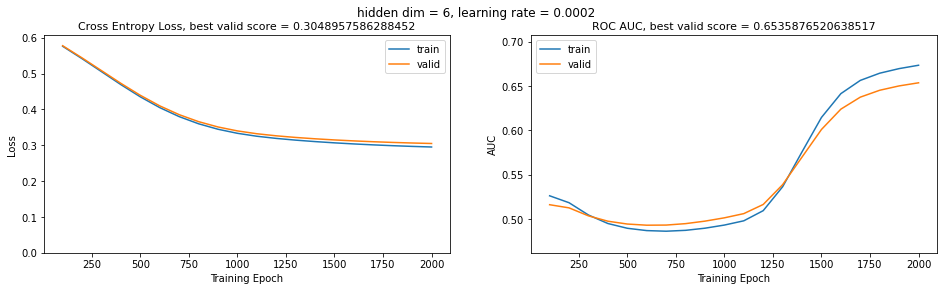

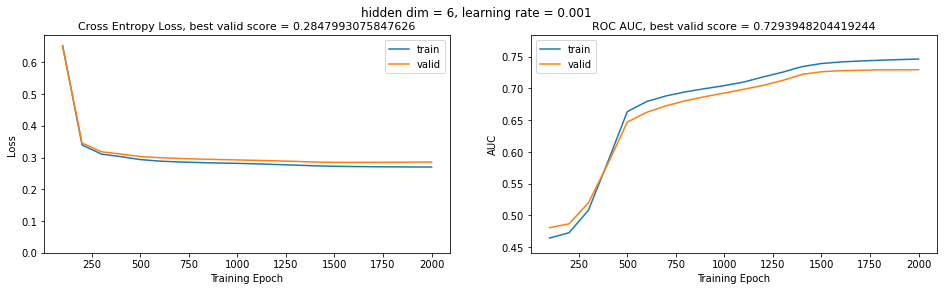

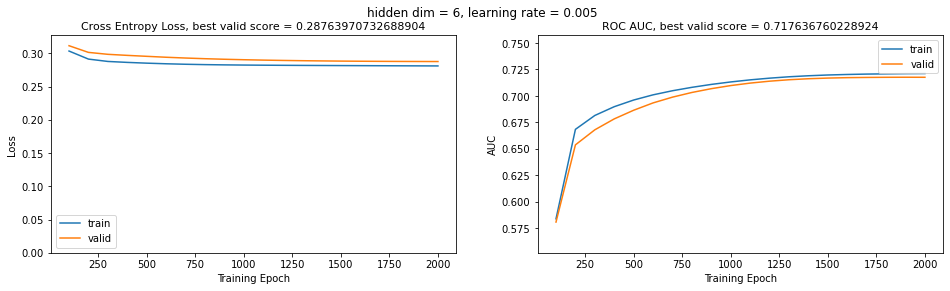

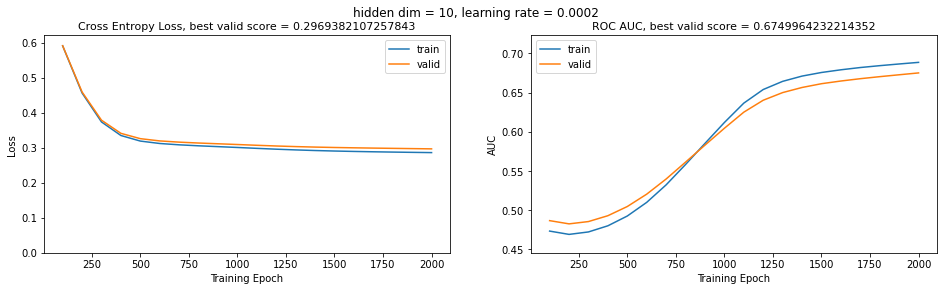

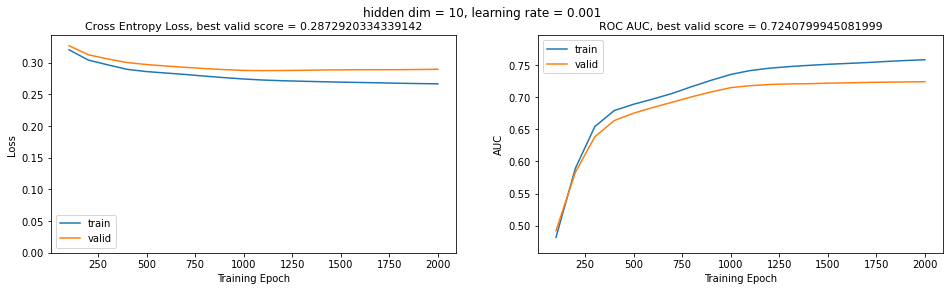

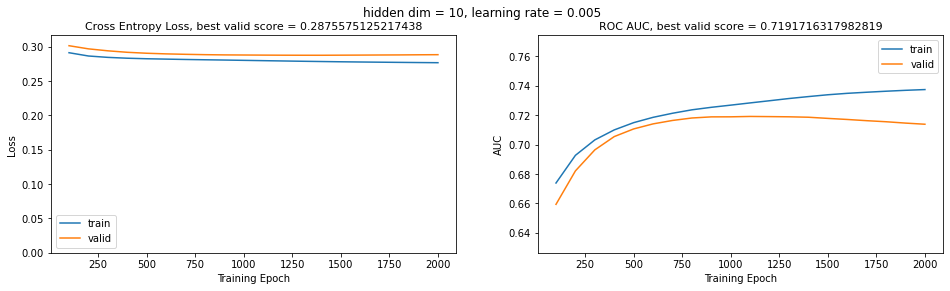

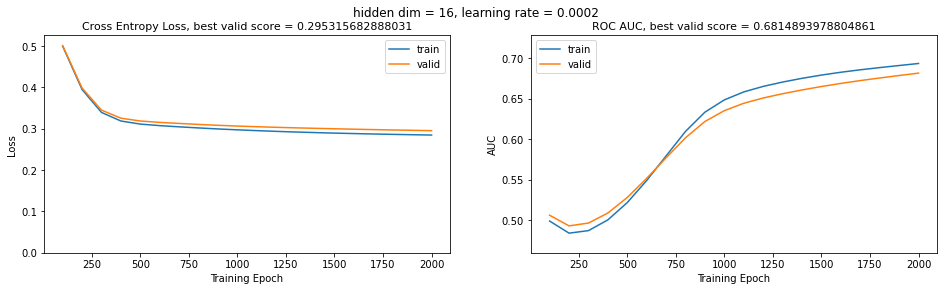

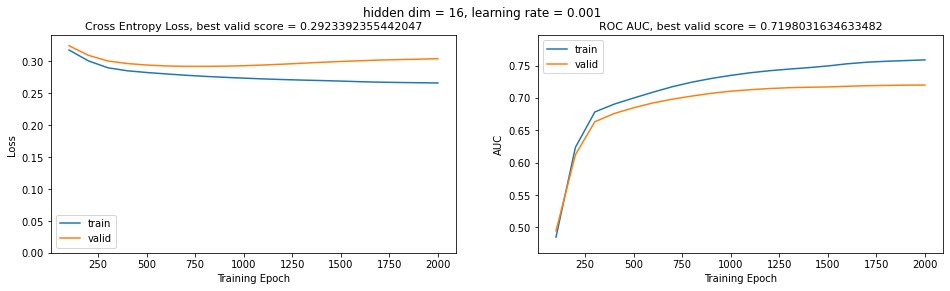

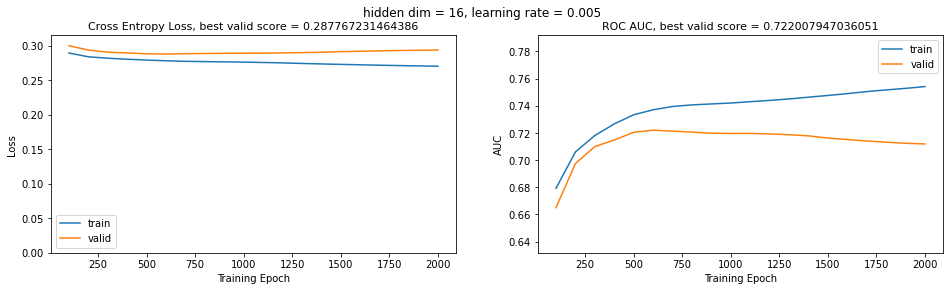

In [10]:
jj=1
for hidden_dim in [6, 10, 16]:
    for lr in [0.0002, 0.001, 0.005]:

        # model class
        class binary_classifier(nn.Module):

            def __init__(self):
                super(binary_classifier,self).__init__()
                self.layer1 = nn.Linear(X_train.shape[1], hidden_dim)
                self.layer2 = nn.Linear(hidden_dim, 2)

            def forward(self,x):
                x = F.relu(self.layer1(x))
                x = self.layer2(x)
                return x

            #This function takes an input and predicts the class, (0 or 1)        
            def predict_class(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                ans = []
                #Pick the class with maximum weight
                for t in pred:
                    if t[0]>t[1]:
                        ans.append(0)
                    else:
                        ans.append(1)
                return torch.tensor(ans)

            def predict_probs(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                return pred
            
        # initialise model
        model = binary_classifier()
        loss_computation = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # trainning
        epochs = 2000
        
        # Store metrics
        epochs_list = []
        losses = []
        losses_valid = []
        train_rocs = []
        valid_rocs = []

        for i in range(epochs):
            y_pred = model.forward(X_train)
            loss = loss_computation(y_pred,y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 100 == 0:
                preds = model.predict_probs(X_train)
                goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
                fpr, tpr, _ = roc_curve(np.array(y_train), preds[:,goal_index].detach().numpy())
                roc_auc = auc(fpr, tpr)

                preds_valid = model.predict_probs(X_valid)
                goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
                fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid), preds_valid[:,goal_index_valid].detach().numpy())
                roc_auc_valid = auc(fpr_valid, tpr_valid)

                y_pred_valid = model.forward(X_valid)
                loss_valid = loss_computation(y_pred_valid, y_valid)

                epochs_list.append(i+1)
                losses.append(loss.item())
                losses_valid.append(loss_valid.item())
                train_rocs.append(roc_auc)
                valid_rocs.append(roc_auc_valid)
            
        # plot metrics
        fig, axs = plt.subplots(1, 2, figsize=(16, 4))
        fig.suptitle(f'hidden dim = {hidden_dim}, learning rate = {lr}')
        axs[0].plot(epochs_list, losses)
        axs[0].plot(epochs_list, losses_valid)
        axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
        axs[0].legend(labels = ['train', 'valid'])
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Training Epoch')
        axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])
        
        axs[1].plot(epochs_list, train_rocs)
        axs[1].plot(epochs_list, valid_rocs)
        axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
        axs[1].legend(labels = ['train', 'valid'])
        axs[1].set_ylabel('AUC')
        axs[1].set_xlabel('Training Epoch')
        axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
        print(jj)
        jj += 1

## 3 layer Neural Net softmax classifier

In [ ]:
jj=1
for hidden_dims in [[16,6], [10,8]]:
    for lr in [0.001, 0.005]:

        # model class
        class binary_classifier(nn.Module):

            def __init__(self):
                super(binary_classifier,self).__init__()
                self.layer1 = nn.Linear(X_train.shape[1], hidden_dims[0])
                self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
                self.layer3 = nn.Linear(hidden_dims[1], 2)

            def forward(self,x):
                x = F.relu(self.layer1(x))
                x = F.relu(self.layer2(x))
                x = self.layer3(x)
                return x

            #This function takes an input and predicts the class, (0 or 1)        
            def predict_class(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                ans = []
                #Pick the class with maximum weight
                for t in pred:
                    if t[0]>t[1]:
                        ans.append(0)
                    else:
                        ans.append(1)
                return torch.tensor(ans)

            def predict_probs(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                return pred
            
        # initialise model
        model = binary_classifier()
        loss_computation = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # trainning
        epochs = 2000
        
        # Store metrics
        epochs_list = []
        losses = []
        losses_valid = []
        train_rocs = []
        valid_rocs = []

        for i in range(epochs):
            y_pred = model.forward(X_train)
            loss = loss_computation(y_pred,y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 100 == 0:
                preds = model.predict_probs(X_train)
                goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
                fpr, tpr, _ = roc_curve(np.array(y_train), preds[:,goal_index].detach().numpy())
                roc_auc = auc(fpr, tpr)

                preds_valid = model.predict_probs(X_valid)
                goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
                fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid), preds_valid[:,goal_index_valid].detach().numpy())
                roc_auc_valid = auc(fpr_valid, tpr_valid)

                y_pred_valid = model.forward(X_valid)
                loss_valid = loss_computation(y_pred_valid, y_valid)

                epochs_list.append(i+1)
                losses.append(loss.item())
                losses_valid.append(loss_valid.item())
                train_rocs.append(roc_auc)
                valid_rocs.append(roc_auc_valid)
            
        # plot metrics
        fig, axs = plt.subplots(1, 2, figsize=(16, 4))
        fig.suptitle(f'hidden dims = {hidden_dims}, learning rate = {lr}')
        axs[0].plot(epochs_list, losses)
        axs[0].plot(epochs_list, losses_valid)
        axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
        axs[0].legend(labels = ['train', 'valid'])
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Training Epoch')
        axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])
        
        axs[1].plot(epochs_list, train_rocs)
        axs[1].plot(epochs_list, valid_rocs)
        axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
        axs[1].legend(labels = ['train', 'valid'])
        axs[1].set_ylabel('AUC')
        axs[1].set_xlabel('Training Epoch')
        axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
        
        print(jj)
        jj += 1

1


## 4 layer Neural Net softmax classifier

In [ ]:
jj=1
for hidden_dims in [[16,10,6]]:
    for lr in [0.001, 0.005]:

        # model class
        class binary_classifier(nn.Module):

            def __init__(self):
                super(binary_classifier,self).__init__()
                self.layer1 = nn.Linear(X_train.shape[1], hidden_dims[0])
                self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
                self.layer3 = nn.Linear(hidden_dims[1], hidden_dims[2])
                self.layer4 = nn.Linear(hidden_dims[2], 2)

            def forward(self,x):
                x = F.relu(self.layer1(x))
                x = F.relu(self.layer2(x))
                x = F.relu(self.layer3(x))
                x = self.layer4(x)
                return x

            #This function takes an input and predicts the class, (0 or 1)        
            def predict_class(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                ans = []
                #Pick the class with maximum weight
                for t in pred:
                    if t[0]>t[1]:
                        ans.append(0)
                    else:
                        ans.append(1)
                return torch.tensor(ans)

            def predict_probs(self,x):
                #Apply softmax to output. 
                pred = F.softmax(self.forward(x), dim=1)
                return pred
            
        # initialise model
        model = binary_classifier()
        loss_computation = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        # trainning
        epochs = 2000
        
        # Store metrics
        epochs_list = []
        losses = []
        losses_valid = []
        train_rocs = []
        valid_rocs = []

        for i in range(epochs):
            y_pred = model.forward(X_train)
            loss = loss_computation(y_pred,y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i+1) % 100 == 0:
                preds = model.predict_probs(X_train)
                goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
                fpr, tpr, _ = roc_curve(np.array(y_train), preds[:,goal_index].detach().numpy())
                roc_auc = auc(fpr, tpr)

                preds_valid = model.predict_probs(X_valid)
                goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
                fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid), preds_valid[:,goal_index_valid].detach().numpy())
                roc_auc_valid = auc(fpr_valid, tpr_valid)

                y_pred_valid = model.forward(X_valid)
                loss_valid = loss_computation(y_pred_valid, y_valid)

                epochs_list.append(i+1)
                losses.append(loss.item())
                losses_valid.append(loss_valid.item())
                train_rocs.append(roc_auc)
                valid_rocs.append(roc_auc_valid)
            
        # plot metrics
        fig, axs = plt.subplots(1, 2, figsize=(16, 4))
        fig.suptitle(f'hidden dims = {hidden_dims}, learning rate = {lr}')
        axs[0].plot(epochs_list, losses)
        axs[0].plot(epochs_list, losses_valid)
        axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
        axs[0].legend(labels = ['train', 'valid'])
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Training Epoch')
        axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])
        
        axs[1].plot(epochs_list, train_rocs)
        axs[1].plot(epochs_list, valid_rocs)
        axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
        axs[1].legend(labels = ['train', 'valid'])
        axs[1].set_ylabel('AUC')
        axs[1].set_xlabel('Training Epoch')
        axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
        
        print(jj)
        jj += 1

## Retrain final model with best hyperparams for a bit longer, log into comet, save model

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import roc_curve, auc
import os
import sys
sys.path.append('../ift6758/data/')

from question_6_m2_neuralnet import *

In [ ]:
experiment = Experiment(
    api_key=os.environ.get("COMET_API_KEY"),
    project_name="neural_net",
    workspace="kleitoun",
)

hidden_dims = [10,8]
lr = 0.005
epochs = 4000

params = {
  "Layer hidden dimensions": hidden_dims,
  "learning rate":lr,
  "epochs":epochs
}

experiment.log_parameters(params)


# model class
class binary_classifier(nn.Module):

    def __init__(self):
        super(binary_classifier,self).__init__()
        self.layer1 = nn.Linear(X_train.shape[1], hidden_dims[0])
        self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.layer3 = nn.Linear(hidden_dims[1], 2)

    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    #This function takes an input and predicts the class, (0 or 1)        
    def predict_class(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

    def predict_probs(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x), dim=1)
        return pred

# initialise model
model = binary_classifier()
loss_computation = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Store metrics
epochs_list = []
losses = []
losses_valid = []
train_rocs = []
valid_rocs = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = loss_computation(y_pred,y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
        preds = model.predict_probs(X_train)
        goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
        fpr, tpr, _ = roc_curve(np.array(y_train), preds[:,goal_index].detach().numpy())
        roc_auc = auc(fpr, tpr)

        preds_valid = model.predict_probs(X_valid)
        goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
        fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid), preds_valid[:,goal_index_valid].detach().numpy())
        roc_auc_valid = auc(fpr_valid, tpr_valid)

        y_pred_valid = model.forward(X_valid)
        loss_valid = loss_computation(y_pred_valid, y_valid)

        epochs_list.append(i+1)
        losses.append(loss.item())
        losses_valid.append(loss_valid.item())
        train_rocs.append(roc_auc)
        valid_rocs.append(roc_auc_valid)

# plot metrics
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle(f'hidden dims = {hidden_dims}, learning rate = {lr}')
axs[0].plot(epochs_list, losses)
axs[0].plot(epochs_list, losses_valid)
axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
axs[0].legend(labels = ['train', 'valid'])
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Training Epoch')
axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])

axs[1].plot(epochs_list, train_rocs)
axs[1].plot(epochs_list, valid_rocs)
axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
axs[1].legend(labels = ['train', 'valid'])
axs[1].set_ylabel('AUC')
axs[1].set_xlabel('Training Epoch')
axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
experiment.log_figure(figure=fig, figure_name='Training Loss and ROC AUC')

metrics = {
    "trainig epoch": epochs_list,
    "trainig loss": losses,
    "validation loss": losses_valid,
    "trainig roc": train_rocs,
    "validation roc": valid_rocs,
}
experiment.log_metrics(metrics)

fig = plot_roc(
    preds_valid[:,goal_index_valid].detach().numpy(),
    y_valid.detach().numpy()
)
experiment.log_figure(figure=fig, figure_name='ROC')

percentile_df = prep_percentile_df(
    y_valid.detach().numpy(), 
    preds_valid[:,goal_index_valid].detach().numpy()
)

fig = plot_goal_rate(percentile_df)
experiment.log_figure(figure=fig, figure_name='Goal Rate')

fig = plot_cum_goal_rate(percentile_df)
experiment.log_figure(figure=fig, figure_name='Cumulative Goal Rate')


fig = plot_calibration_curve(
    y_valid.detach().numpy(), 
    preds_valid[:,goal_index_valid].detach().numpy()
)
experiment.log_figure(figure=fig, figure_name='Calibration Curve')

torch.save(model.state_dict(), 'q6_neural_net_final')
experiment.log_model('nn_final', 'q6_neural_net_final')

experiment.end()

## Retrain same model with random train/valid split, log into comet, save model

In [ ]:
experiment = Experiment(
    api_key= os.environ.get("COMET_API_KEY"),
    project_name="neural_net",
    workspace="kleitoun",
)

hidden_dims = [10,8]
lr = 0.005
epochs = 4000

params = {
  "Layer hidden dimensions": hidden_dims,
  "learning rate":lr,
  "epochs":epochs
}

experiment.log_parameters(params)


# model class
class binary_classifier(nn.Module):

    def __init__(self):
        super(binary_classifier,self).__init__()
        self.layer1 = nn.Linear(X_train2.shape[1], hidden_dims[0])
        self.layer2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.layer3 = nn.Linear(hidden_dims[1], 2)

    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    #This function takes an input and predicts the class, (0 or 1)        
    def predict_class(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x), dim=1)
        ans = []
        #Pick the class with maximum weight
        for t in pred:
            if t[0]>t[1]:
                ans.append(0)
            else:
                ans.append(1)
        return torch.tensor(ans)

    def predict_probs(self,x):
        #Apply softmax to output. 
        pred = F.softmax(self.forward(x), dim=1)
        return pred

# initialise model
model = binary_classifier()
loss_computation = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Store metrics
epochs_list = []
losses = []
losses_valid = []
train_rocs = []
valid_rocs = []

for i in range(epochs):
    y_pred = model.forward(X_train2)
    loss = loss_computation(y_pred,y_train2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
        preds = model.predict_probs(X_train2)
        goal_index = np.argmin(preds.sum(dim=0).detach().numpy())
        fpr, tpr, _ = roc_curve(np.array(y_train2), preds[:,goal_index].detach().numpy())
        roc_auc = auc(fpr, tpr)

        preds_valid = model.predict_probs(X_valid2)
        goal_index_valid = np.argmin(preds_valid.sum(dim=0).detach().numpy())
        fpr_valid, tpr_valid, _ = roc_curve(np.array(y_valid2), preds_valid[:,goal_index_valid].detach().numpy())
        roc_auc_valid = auc(fpr_valid, tpr_valid)

        y_pred_valid = model.forward(X_valid2)
        loss_valid = loss_computation(y_pred_valid, y_valid2)

        epochs_list.append(i+1)
        losses.append(loss.item())
        losses_valid.append(loss_valid.item())
        train_rocs.append(roc_auc)
        valid_rocs.append(roc_auc_valid)

# plot metrics
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle(f'hidden dims = {hidden_dims}, learning rate = {lr}')
axs[0].plot(epochs_list, losses)
axs[0].plot(epochs_list, losses_valid)
axs[0].set_title(f'Cross Entropy Loss, best valid score = {min(losses_valid)}', fontsize=11)
axs[0].legend(labels = ['train', 'valid'])
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Training Epoch')
axs[0].set_ylim([0, 1.05*max([max(losses), max(losses_valid)])])

axs[1].plot(epochs_list, train_rocs)
axs[1].plot(epochs_list, valid_rocs)
axs[1].set_title(f'ROC AUC, best valid score = {max(valid_rocs)}', fontsize=11)
axs[1].legend(labels = ['train', 'valid'])
axs[1].set_ylabel('AUC')
axs[1].set_xlabel('Training Epoch')
axs[1].set_ylim([ 0.95*min([min(train_rocs), min(valid_rocs)]), 1.05*max([max(train_rocs), max(valid_rocs)])])
experiment.log_figure(figure=fig, figure_name='Training Loss and ROC AUC')

metrics = {
    "trainig epoch": epochs_list,
    "trainig loss": losses,
    "validation loss": losses_valid,
    "trainig roc": train_rocs,
    "validation roc": valid_rocs,
}
experiment.log_metrics(metrics) 

fig = plot_roc(
    preds_valid[:,goal_index_valid].detach().numpy(),
    y_valid2.detach().numpy(),
    save_path = 'Q6_neural_net_ROC_Curve_random_split.png'
)
experiment.log_figure(figure=fig, figure_name='ROC')

percentile_df = prep_percentile_df(
    y_valid2.detach().numpy(), 
    preds_valid[:,goal_index_valid].detach().numpy()
)

fig = plot_goal_rate(percentile_df, save_path='Q6_neural_net_Goal_Rate_random_split.png')
experiment.log_figure(figure=fig, figure_name='Goal Rate')

fig = plot_cum_goal_rate(percentile_df, save_path='Q6_neural_net_Cum_Goal_random_split.png')
experiment.log_figure(figure=fig, figure_name='Cumulative Goal Rate')


fig = plot_calibration_curve(
    y_valid2.detach().numpy(), 
    preds_valid[:,goal_index_valid].detach().numpy(),
    save_path ='Q6_neural_net_Calibration_Curve_random_split.png'
)
experiment.log_figure(figure=fig, figure_name='Calibration Curve')

torch.save(model.state_dict(), 'q6_neural_net_final_random_split')
experiment.log_model('nn_final_random_split', 'q6_neural_net_final_random_split')

experiment.end()